# 'Le Bon Coin.com' web scrapping

<p>
This code scraps leboncoin.com and get every Renault Zoe in different departments.<br\>
Then it does a data visualiaation
</p>

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns

/cal/softs/anaconda/anaconda-2.0.1/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Get text from url
def requestPage(url):
    request = requests.get(url)
    soup = BeautifulSoup(request.text, 'html.parser')
    return soup

In [3]:
versionList = ['zen', 'life', 'intens']
# Get version of the car
def getVersion(text):
    answer = None
    for version in versionList:
        if(version.lower() in text.lower()):
            answer = version
            break
    return answer

In [4]:
# Get category
def getCategory(text):
    category = None
    m = re.search(r'\((.*?)\)',text)
    if m:
        category = m.group(1)
    else:
        category = 'particulier'
    return category

In [5]:
# Get price
def getPrix(text):
    prix = None
    m = re.search(r'Prix :[\s\n\r]+(.*?)€',text)
    if m:
        prix = m.group(1)
    return prix

In [6]:
# Get year
def getAnneeModele(text):
    anneeModele = None
    m = re.search(r'Année-modèle :[\s\n\r]+(\d+)\D',text)
    if m:
        anneeModele = m.group(1)
    return anneeModele

In [7]:
# Get km
def getKilometrage(text):
    kilometrage = None
    m = re.search(r'Kilométrage :[\s\n\r]+(.*?)KM',text)
    if m:
        kilometrage = m.group(1)
    return kilometrage

In [8]:
# Get phone number
def getPhoneNumber(text):
    phoneNumber = None
    m = re.search(r'0[1-68][0-9]{8}',text)
    if m:
        phoneNumber = m.group(0)
    return phoneNumber

In [9]:
# compare mean price and car's price
def compareCote(cote, prix):
    compare = None
    if(cote > prix):
        compare = '+'
    elif(cote<prix):
        compare = '-'
    elif(cote == prix):
        compare = '='
    return compare

In [10]:
# Build a dictionary
def buildDict(argusDict, version, category, prix, anneeModele, kilometrage, phone, location):
    dico = {}
    if version:
        dico['version'] = version
    if category:
        dico['category'] = category
    if prix:
        dico['prix'] = int(prix.replace(" ", "").replace("\xc2\xa0", ""))
    if anneeModele:
        dico['anneeModele'] = anneeModele
    if kilometrage:
        dico['kilometrage'] = kilometrage.replace(" ", "")
    if phone:
        dico['phone'] = phone
    if location:
        dico['location'] = location
    
    cote = argusDict.get(version)
    if version:
        dico['cote'] = int(cote.replace(" ", ""))

    if cote and prix:
        dico['compare'] = compareCote(int(cote.replace(" ", "")), int(prix.replace(" ", "").replace("\xc2\xa0", "")))
    
    return dico

In [11]:
def getInformation(mainDico, argusDict, i, location, url):
    soup = requestPage(url)
    wholeContent = soup.find("div", { "class" : "list-lbc" })
    table = wholeContent.find_all('a', href=True)

    for link in table:
    # Version de la voiture
        version = getVersion(link['title'])
    # Categorie de l'annonce 
        catText = link.find("div", { "class" : "category"}).text
        category = getCategory(catText)

        href = link['href']
        subPage = requestPage(link['href'])
        content = subPage.find("div", {"class" : "lbcParamsContainer floatLeft"}).text.encode('utf-8')
        content2 = subPage.find("div", {"class" : "AdviewContent"}).text.encode('utf-8')

    # Prix de la voiture
        prix = getPrix(content)
    # AnneeModele
        anneeModele = getAnneeModele(content)
    # Kilometrage
        kilometrage = getKilometrage(content)
    # Phone number
        phone = getPhoneNumber(content2)
        
        item = buildDict(argusDict, version, category, prix, anneeModele, kilometrage, phone, location)
        mainDico[i] = item
        i+=1
    #     break
    return mainDico, i

In [12]:
# Get Argus content
def getInfoArgus(url):
    soup = requestPage(url)
    coteArgus = soup.find("span", {"class": "Result_Cote arial tx20"})

    m = re.search(r'(.*?)€',coteArgus.text.encode('utf-8'))
    cote = ''
    if m:
        cote = m.group(1)
    return cote

In [13]:
# Get Argu price
def getArgusCote():
    urlArgus = 'http://www.lacentrale.fr/cote-voitures-renault-zoe--2013-.html'

    soup = requestPage(urlArgus)

    argusContent = soup.find("div", { "id" : "listing_quot" })
    tableArgus = argusContent.find_all('a', href=True)

    setArgus = set()
    for lin in tableArgus:
        setArgus.add('http://www.lacentrale.fr/'+lin['href'])

    argusDict = {}
    for link in setArgus:
        version = getVersion(link)
        cote = getInfoArgus(link)
        argusDict[version] = cote
    
    return argusDict
# print pd.DataFrame.from_dict(argusDict, orient='index')

In [14]:
url = 'http://www.leboncoin.fr/voitures/offres/%LOCATION/?f=a&th=1&q=Renault+Zoe&it=1'
locations = [ 'aquitaine', 'provence_alpes_cote_d_azur', 'ile_de_france']

mainDico = {}
i=0
argusDict = getArgusCote()
for loc in locations:
    mainDico, i = getInformation(mainDico, argusDict, i, loc, url.replace('%LOCATION', loc))

In [15]:
df = pd.DataFrame.from_dict(mainDico, orient='index')
df.head(5)

,category,cote,kilometrage,compare,prix,version,location,anneeModele,phone
0,pro,10500,14077,-,11800,zen,aquitaine,2013,NaN
1,particulier,10500,33000,-,11000,zen,aquitaine,2013,NaN
2,pro,10400,33272,+,9890,life,aquitaine,2013,0531081576
3,pro,11100,11500,-,14900,intens,aquitaine,2015,NaN
4,pro,10400,18766,+,8900,life,aquitaine,2013,0531081574


In [16]:
subDf = df.loc[:,['version', 'prix', 'cote', 'location']]
subDf = subDf.dropna()
subDf.head(5)

,version,prix,cote,location
0,zen,11800,10500,aquitaine
1,zen,11000,10500,aquitaine
2,life,9890,10400,aquitaine
3,intens,14900,11100,aquitaine
4,life,8900,10400,aquitaine


In [17]:
lifeDf = subDf[subDf['version'] == 'life']
zenDf = subDf[subDf['version'] == 'zen']
intensDf = subDf[subDf['version'] == 'intens']

In [18]:
%matplotlib inline

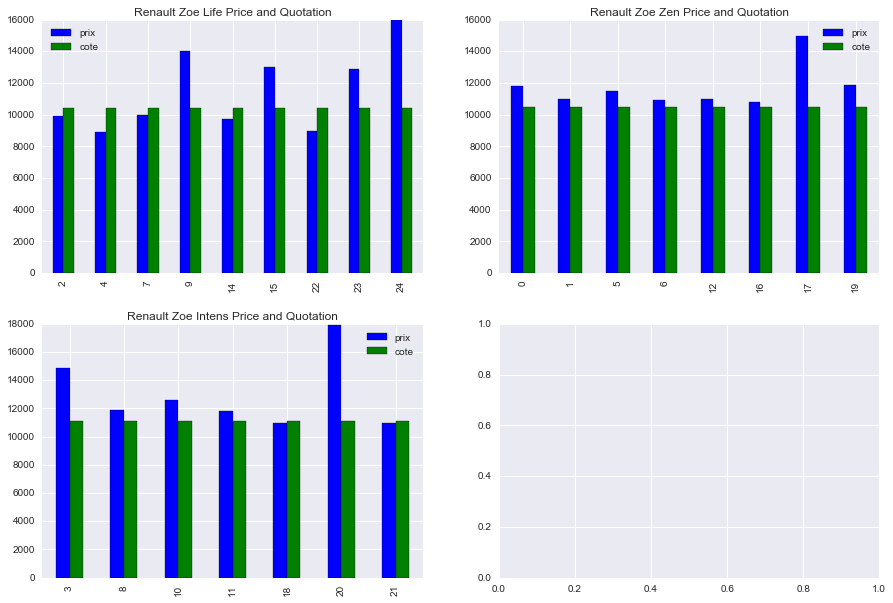

In [19]:

fig, axes = plt.subplots(nrows=2, ncols=2)
lifeDf.plot(ax=axes[0,0], title='Renault Zoe Life Price and Quotation', figsize=(15,10), kind='bar')
zenDf.plot(ax=axes[0,1], title='Renault Zoe Zen Price and Quotation', figsize=(15,10), kind='bar')
intensDf.plot(ax=axes[1,0], title='Renault Zoe Intens Price and Quotation', figsize=(15,10), kind='bar')

<p>
On the previous graphs, we can visualize the price of the different Renault Zoe version compare to the quotation.
<br\><br\>
For the Renault Life, the price is either below the quotation or above
However, for the Renault Zen, the price is always above the quotation.
As for Renault Intens, the price is either higher or almost the same than the quotation.
</p>

In [20]:
lifeIleDeFranceDf = lifeDf[lifeDf['location'] == 'ile_de_france']
zenIleDeFranceDf = zenDf[zenDf['location'] == 'ile_de_france']
intensIleDeFranceDf = intensDf[intensDf['location'] == 'ile_de_france']

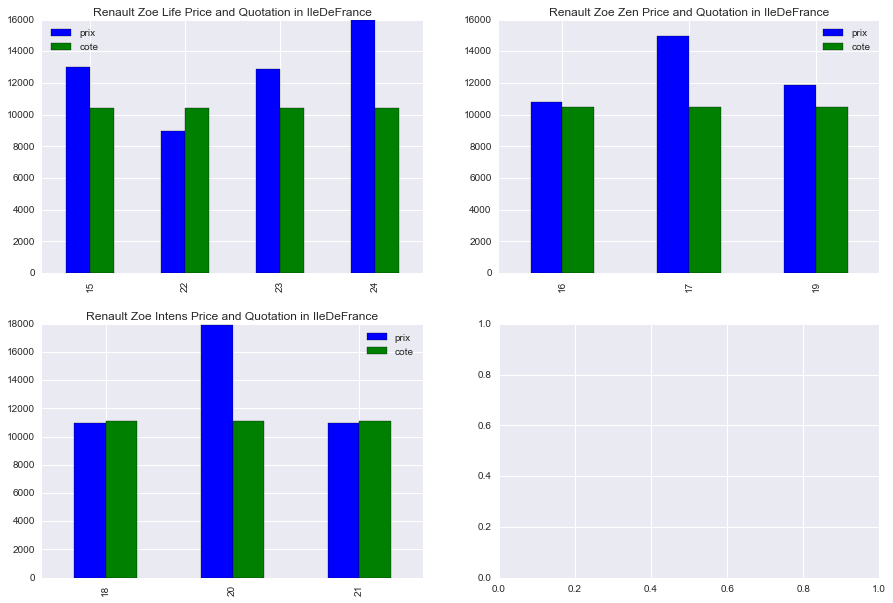

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2)
lifeIleDeFranceDf.plot(ax=axes[0,0], title='Renault Zoe Life Price and Quotation in IleDeFrance', figsize=(15,10), kind='bar')
zenIleDeFranceDf.plot(ax=axes[0,1], title='Renault Zoe Zen Price and Quotation in IleDeFrance', figsize=(15,10), kind='bar')
intensIleDeFranceDf.plot(ax=axes[1,0], title='Renault Zoe Intens Price and Quotation in IleDeFrance', figsize=(15,10), kind='bar')

In [22]:
lifePACADf = lifeDf[lifeDf['location'] == 'provence_alpes_cote_d_azur']
zenPACADf = zenDf[zenDf['location'] == 'provence_alpes_cote_d_azur']
intensPACADf = intensDf[intensDf['location'] == 'provence_alpes_cote_d_azur']

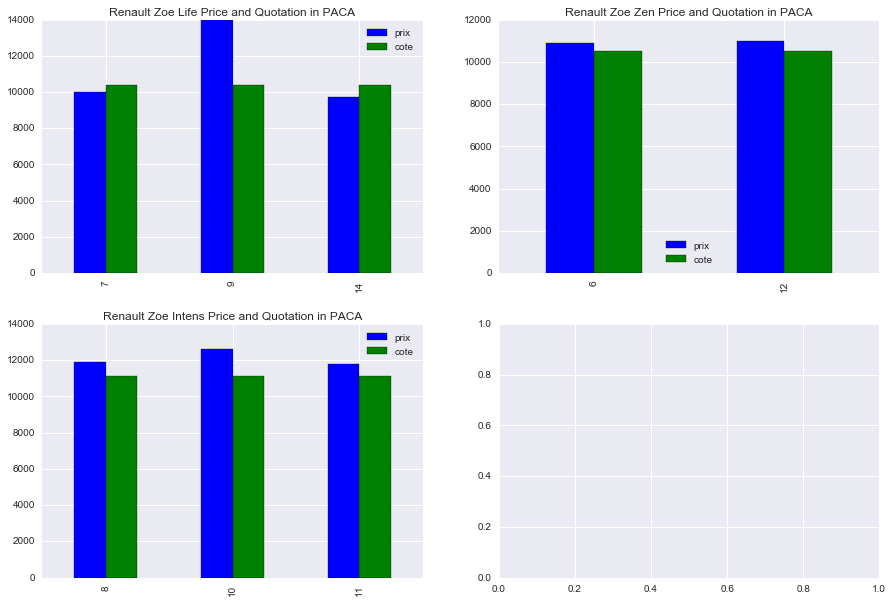

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2)
lifePACADf.plot(ax=axes[0,0], title='Renault Zoe Life Price and Quotation in PACA', figsize=(15,10), kind='bar')
zenPACADf.plot(ax=axes[0,1], title='Renault Zoe Zen Price and Quotation in PACA', figsize=(15,10), kind='bar')
intensPACADf.plot(ax=axes[1,0], title='Renault Zoe Intens Price and Quotation in PACA', figsize=(15,10), kind='bar')

In [24]:
lifeAquitaineDf = lifeDf[lifeDf['location'] == 'aquitaine']
zenAquitaineDf = zenDf[zenDf['location'] == 'aquitaine']
intensAquitaineDf = intensDf[intensDf['location'] == 'aquitaine']

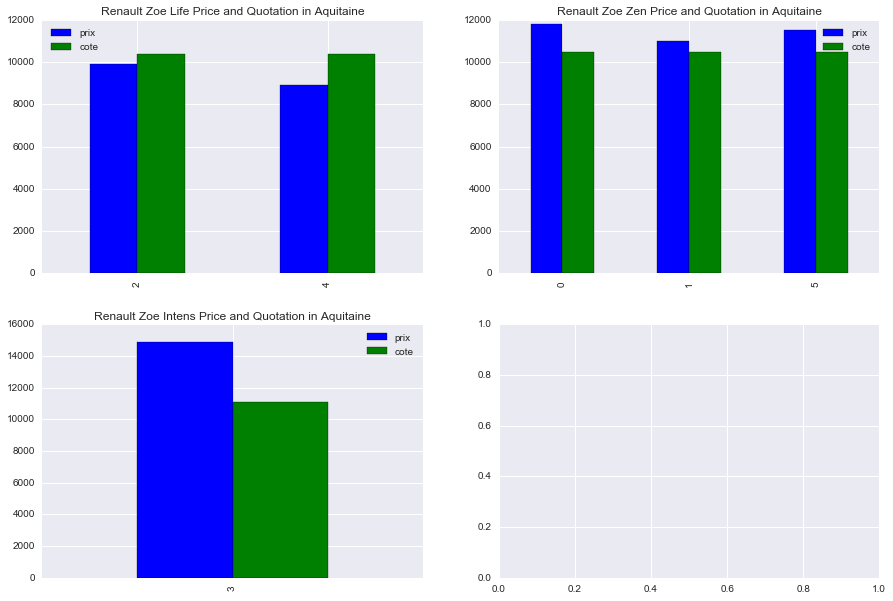

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2)
lifeAquitaineDf.plot(ax=axes[0,0], title='Renault Zoe Life Price and Quotation in Aquitaine', figsize=(15,10), kind='bar')
zenAquitaineDf.plot(ax=axes[0,1], title='Renault Zoe Zen Price and Quotation in Aquitaine', figsize=(15,10), kind='bar')
intensAquitaineDf.plot(ax=axes[1,0], title='Renault Zoe Intens Price and Quotation in Aquitaine', figsize=(15,10), kind='bar')

<p>
In the three subplots above, we have plot(bar) the price of each version of the model in the three different departments.
<br\>
We can visualize the price of the different model in one department.
<br\><br\>
For example, in Aquitaine, the price of Renault Life is below the quotation. Whereas the price of Renault Zen and Intens, the selling price is always above the quotation.
</p>